In [1]:
import json
import pandas as pd
import math

%matplotlib inline

In [2]:
# reading the JSON data using json.load()
file = './data/GoogleLocation.json'
with open(file) as train_file:
    data_json = json.load(train_file)
    
df = pd.DataFrame({'raw': data_json['locations']})

In [3]:
# Extract the base data
df['timestampMs'] = df.apply(lambda row: int(row['raw']['timestampMs']), axis=1)
df['latitudeE7'] = df.apply(lambda row: row['raw']['latitudeE7'], axis=1)
df['longitudeE7'] = df.apply(lambda row: row['raw']['longitudeE7'], axis=1)
df['accuracy'] = df.apply(lambda row: row['raw']['accuracy'], axis=1)

In [4]:
# Derivatives
df['date'] = pd.to_datetime(df.timestampMs, unit='ms')
df['year'] = df.apply(lambda row: row['date'].year, axis=1)
df['month'] = df.apply(lambda row: row['date'].month, axis=1)
df['day'] = df.apply(lambda row: row['date'].day, axis=1)

df['time_of_day'] = (df.timestampMs % (1000*60*60*24)) / (1000*60*60)
df['duration'] = df.timestampMs.diff()*-1

In [5]:
df.head()

,raw,timestampMs,latitudeE7,longitudeE7,accuracy,date,year,month,day,time_of_day,duration
0,"{'timestampMs': '1535206580750', 'latitudeE7':...",1535206580750,508757910,46904144,16,2018-08-25 14:16:20.750,2018,8,25,14.272431,NaN
1,"{'timestampMs': '1535206557560', 'latitudeE7':...",1535206557560,508756268,46905213,31,2018-08-25 14:15:57.560,2018,8,25,14.265989,23190.0
2,"{'timestampMs': '1535206542536', 'latitudeE7':...",1535206542536,508757105,46904621,13,2018-08-25 14:15:42.536,2018,8,25,14.261816,15024.0
3,"{'timestampMs': '1535206522420', 'latitudeE7':...",1535206522420,508757299,46904508,10,2018-08-25 14:15:22.420,2018,8,25,14.256228,20116.0
4,"{'timestampMs': '1535206502307', 'latitudeE7':...",1535206502307,508757320,46904443,10,2018-08-25 14:15:02.307,2018,8,25,14.250641,20113.0


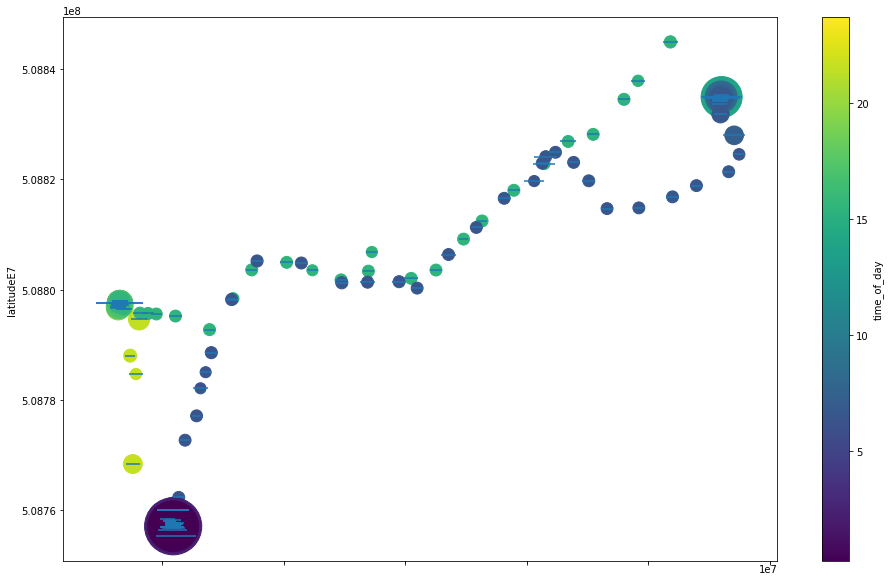

In [6]:
df_part = pd.DataFrame(df[(df.accuracy<100) & (df.year==2018) & (df.month==7) & (df.day==17)])
df_part['duration'] = df_part.timestampMs.diff()*-1
df_part['sqrt_duration'] = df_part.apply(lambda row: math.sqrt(row.duration), axis=1)

df_part.plot.scatter(x='longitudeE7', xerr=df_part.accuracy*200, y='latitudeE7', c='time_of_day', s=df_part.sqrt_duration, figsize=(16, 10), colormap='viridis')

In [7]:
df_part['activity_raw'] = df_part.apply(lambda row: row['raw'].get('activity'), axis=1)

def gather_confidences(activities_raw, types):
    if activities_raw == None:
        return []
    
    found = []
    for activity in activities_raw:
        options = activity['activity']
        
        if options[0]['type'] == 'TILTING':
            continue
        
        confidence = 0
        for act_type in types:
            for act in filter(lambda act: act['type'] == act_type, options):
                confidence += act['confidence']
        found.append(confidence)
    return found

df_part['still_confidence'] = df_part.apply(lambda row: gather_confidences(row.activity_raw, ['STILL']), axis=1)
df_part['moving_confidence'] = df_part.apply(lambda row: gather_confidences(row.activity_raw, ['ON_FOOT', 'IN_VEHICLE', 'ON_BICYCLE']), axis=1)

In [8]:
df_part.describe()

,timestampMs,latitudeE7,longitudeE7,accuracy,year,month,day,time_of_day,duration,sqrt_duration
count,4.220000e+02,4.220000e+02,4.220000e+02,422.000000,422.0,422.0,422.0,422.000000,4.210000e+02,421.000000
mean,1.531834e+12,5.088064e+08,4.699341e+07,16.405213,2018.0,7.0,17.0,13.358361,2.014051e+05,356.760157
std,1.958263e+07,2.707438e+04,1.148025e+05,5.649230,0.0,0.0,0.0,5.439621,6.373194e+05,272.587248
min,1.531787e+12,5.087553e+08,4.688195e+07,10.000000,2018.0,7.0,17.0,0.295509,5.200000e+01,7.211103
25%,1.531814e+12,5.087975e+08,4.688258e+07,14.000000,2018.0,7.0,17.0,7.998241,2.185800e+04,147.844513
50%,1.531834e+12,5.087979e+08,4.690492e+07,15.000000,2018.0,7.0,17.0,13.462329,1.208710e+05,347.665069
75%,1.531850e+12,5.088348e+08,4.712988e+07,16.000000,2018.0,7.0,17.0,17.985989,2.321080e+05,481.775882
max,1.531871e+12,5.088449e+08,4.713727e+07,49.000000,2018.0,7.0,17.0,23.848719,1.065935e+07,3264.865388


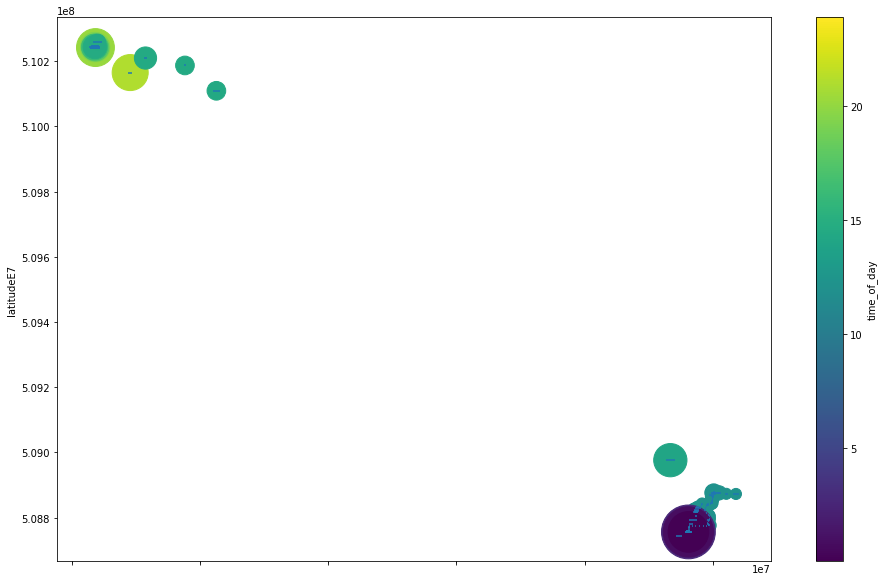

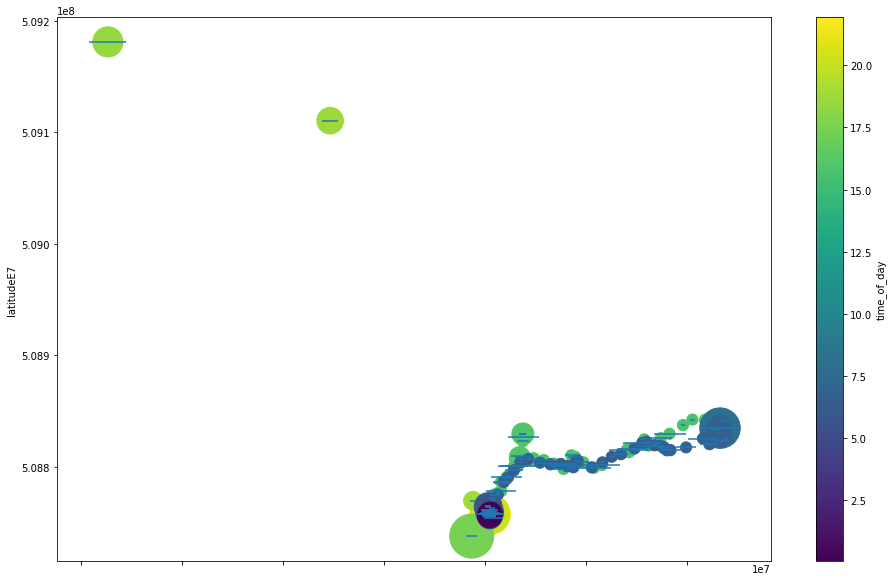

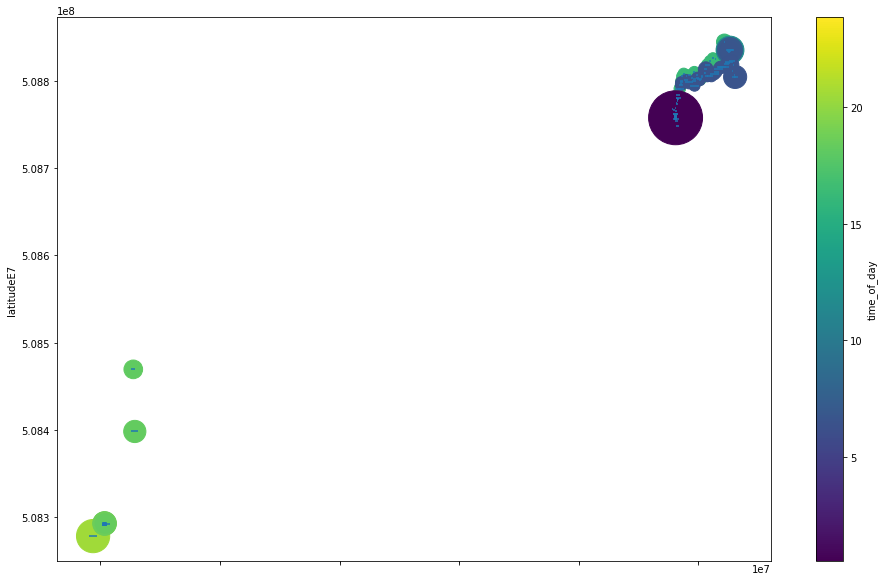

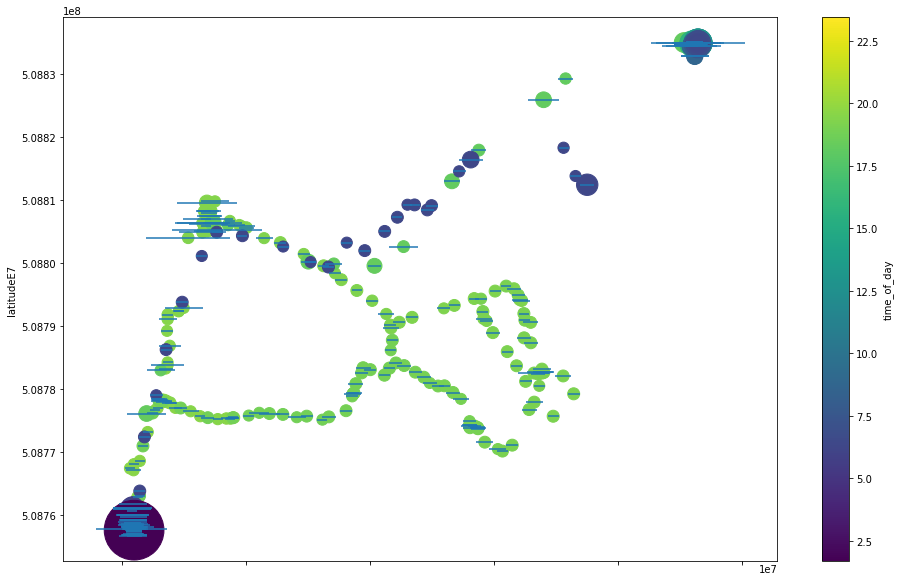

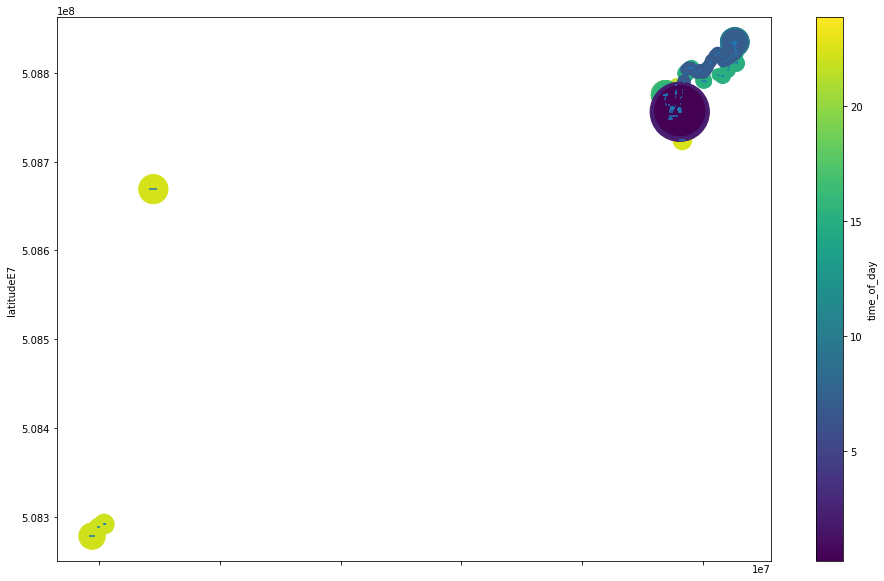

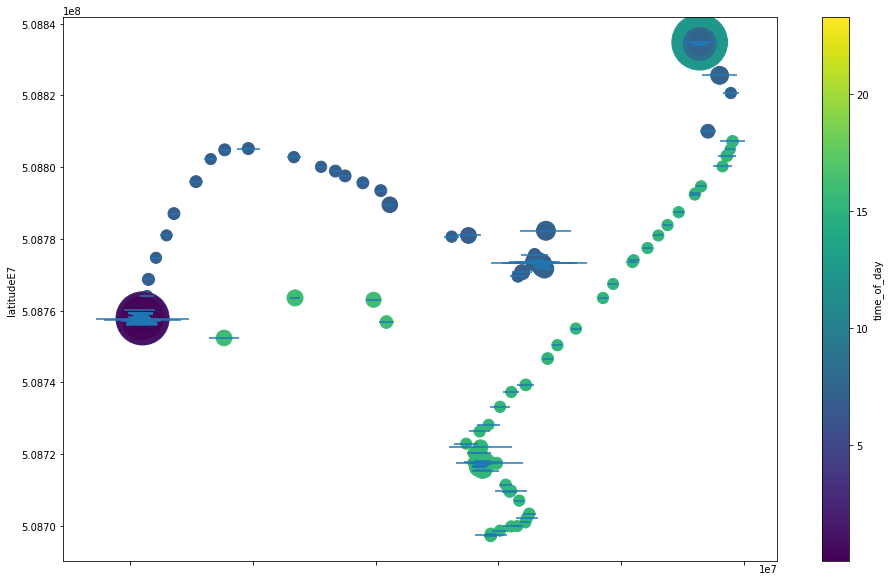

In [9]:
def plot_single_day(year, month, day):
    df_part = pd.DataFrame(df[(df.accuracy < 100) & (df.year==year) & (df.month==month) & (df.day==day)])
    df_part['duration'] = df_part.timestampMs.diff()*-1
    df_part['sqrt_duration'] = df_part.apply(lambda row: math.sqrt(row.duration), axis=1)

    df_part.plot.scatter(x='longitudeE7', xerr=df_part.accuracy*200, y='latitudeE7', c='time_of_day', s=df_part.sqrt_duration, figsize=(16, 10), colormap='viridis')

for i in range(1, 7):
    plot_single_day(2018, 7, i)